# 圆形路牌的检测

王佳栋

2018年11月22日



In [71]:
# To run this code, you need to precise the name of the image file 
# and one parameter representing a threshold representing the level of circles we will keep
path = 'RTS02.jpg'
threshold =0.9

#path = 'RTS03.jpg'
#threshold =0.95

path = 'RTS04.jpg'
threshold =0.9


In [72]:
%matplotlib inline

In [73]:
import numpy as np
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
from pylab import *
import math
import cv2
#from skimage import morphology
import time

In [74]:
def show_fromarray(pix):
    im_temp = Image.fromarray(pix)
    imshow(im_temp)
    show()

In [75]:
original = Image.open(path)


Original Image in Gray-Scale


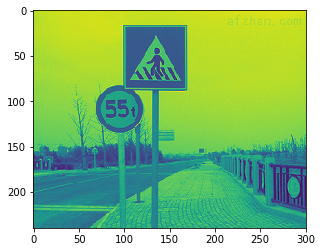

Gaussian Blur


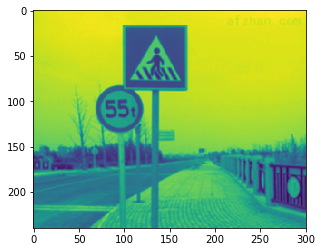

Canny Edge Detection


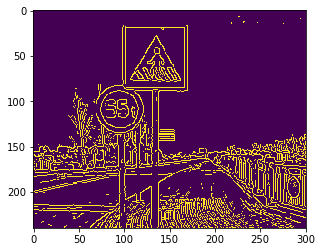

In [76]:
# Read the image
pix1 = cv2.imread(path,0)
print('Original Image in Gray-Scale')
show_fromarray(pix1)

# Gaussian Blur
blur1 = cv2.GaussianBlur(pix1,(3,3),0)
print('Gaussian Blur')
show_fromarray(blur1)

# Canny Edge Detection
canny1 = cv2.Canny(pix1,80,100)
print('Canny Edge Detection')
show_fromarray(canny1)

Projection of accumulator in (x,y) plan


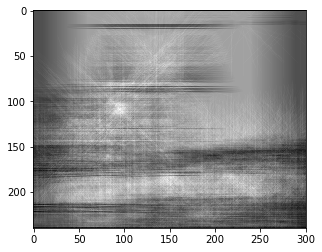

Projection of accumulator after NMS in (x,y) plan


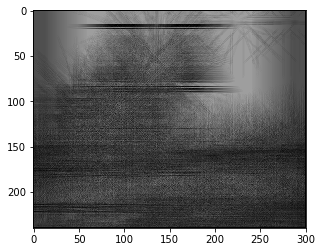

This step takes 37.096143 seconds


In [77]:
t1 = time.time()
# 累加函数
def accumulate(accumulator,  GradX, GradY, X,Y, min_R = 5, max_R = 40):
    if GradX ==0:
        for i in range(Y-max_R, Y-min_R):
            if 0<=i<accumulator.shape[1]:
                accumulator[X,i,abs(Y-i)] += 1
        for i in range(Y+min_R, Y+max_R):
            if 0<=i<accumulator.shape[1]:
                accumulator[X,i,abs(Y-i)]+=1
    else:
        for i in range(max_R):
            if np.abs(GradX)>np.abs(GradY):
                r = int(math.sqrt(i**2+(i*GradY/GradX)**2))
                if min_R<=r<=max_R:
                    if 0<=X+i<accumulator.shape[0] and 0<=round(Y+i*GradY/GradX)<accumulator.shape[1]:
                        accumulator[X+i, int(round(Y+i*GradY/GradX)), r] += 1  
                    if 0<=X-i<accumulator.shape[0] and 0<=round(Y-i*GradY/GradX)<accumulator.shape[1]:
                        accumulator[X-i, int(round(Y-i*GradY/GradX)),r] += 1
            else:
                r = int(math.sqrt(i**2+(i*GradX/GradY)**2))
                if min_R<=r<=max_R:
                    if 0<=Y+i<accumulator.shape[1] and 0<=round(X+i*GradX/GradY)<accumulator.shape[0]:
                        accumulator[int(round(X+i*GradX/GradY)), Y+i,r] += 1  
                    if 0<=Y-i<accumulator.shape[1] and 0<=round(X-i*GradX/GradY)<accumulator.shape[0]:
                        accumulator[int(round(X-i*GradX/GradY)), Y-i,r] += 1 
    return accumulator

min_R = 10
max_R = 60                

# 初始化累加器
accumulator = np.zeros([canny1.shape[0],canny1.shape[1],max_R+1])

# 使用Sobel Filter计算各个位置的梯度
KernX = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])*(-1)        
KernY = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*(-1)

GradX = np.zeros(canny1.shape)
GradY = np.zeros(canny1.shape)

# 在（x,y,r）空间进行累加
for i in range(1,canny1.shape[0]-1):
    for j in range(1,canny1.shape[1]-1):
        # 计算每个点的梯度方向
            GradX[i,j] = np.sum(KernX*canny1[i-1:i+2,j-1:j+2])
            GradY[i,j] = np.sum(KernY*canny1[i-1:i+2,j-1:j+2])
            accumulator = accumulate(accumulator, GradX[i,j], GradY[i,j], i,j, min_R=min_R, max_R =max_R)

# 显示累加器结果在(x,y)平面上的投影            
print('Projection of accumulator in (x,y) plan')
show_fromarray(np.sum(accumulator,axis=2)/np.max(np.sum(accumulator,axis=2))*255)   
show()

# 6方向非极大值抑制 Non-Maximum Suppression，NMS
accumulator_2 = np.zeros(accumulator.shape)
for i in range(1,accumulator.shape[0]-1):
    for j in range(1,accumulator.shape[1]-1):
        for k in range(1,accumulator.shape[2]-1):
            if accumulator[i,j,k]>= max([accumulator[i-1,j,k],accumulator[i+1,j,k],accumulator[i,j-1,k],accumulator[i,j+1,k],accumulator[i,j,k-1],accumulator[i,j,k+1]]):
                accumulator_2[i,j,k] = accumulator[i,j,k]
print('Projection of accumulator after NMS in (x,y) plan')

show_fromarray(np.sum(accumulator_2,axis=2)/np.max(np.sum(accumulator,axis=2))*255)      
show()

t2=time.time()
print('This step takes %f seconds' %(t2-t1))

14.0
find a cercle with center [ 108 , 94 ], and with radius 25 
find a cercle with center [ 108 , 96 ], and with radius 25 


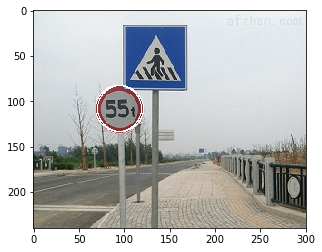

In [78]:
print(np.max(accumulator_2))
acc_max = np.max(accumulator_2)
im2 = original
draw2 = ImageDraw.Draw(im2)
for i in range(1,canny1.shape[0]-1):
    for j in range(1,canny1.shape[1]-1):
        for k in range(max_R):
            if accumulator_2[i,j,k]>acc_max*threshold:
                #draw1.ellipse([j-2,i-2,j+2,i+2],fill=0)
                draw2.ellipse([j-k,i-k,j+k,i+k])
                print('find a cercle with center [ %d , %d ], and with radius %d ' %(i,j,k))
#del draw1
del draw2
#imshow(im1)
#show()
imshow(im2)
show()

In [20]:
'''
def accumulate(accumulator, dic1, GradX, GradY, X,Y, min_R = 5, max_R = 40):
    if GradX ==0:
        for i in range(Y-max_R, Y-min_R):
            if 0<=i<accumulator.shape[1]:
                accumulator[X,i]+=1
                newset = dic1.get((X,i))
                newset.add((X,Y))
                dic1.update({(X,i):newset})
        for i in range(Y+min_R, Y+max_R):
            if 0<=i<accumulator.shape[1]:
                accumulator[X,i]+=1
                newset = dic1.get((X,i))
                newset.add((X,Y))
                dic1.update({(X,i):newset})
    else:
        for i in range(min_R, max_R):
            if np.abs(GradX)>np.abs(GradY):
                if 0<=X+i<accumulator.shape[0] and 0<=round(Y+i*GradY/GradX)<accumulator.shape[1]:
                    accumulator[X+i, int(round(Y+i*GradY/GradX))] += 1
                    newset = dic1.get((X+i, int(round(Y+i*GradY/GradX))))
                    newset.add((X,Y))
                    dic1.update({(X+i, int(round(Y+i*GradY/GradX))):newset})       
                if 0<=X-i<accumulator.shape[0] and 0<=round(Y-i*GradY/GradX)<accumulator.shape[1]:
                    accumulator[X-i, int(round(Y-i*GradY/GradX))] += 1
                    newset = dic1.get((X-i, int(round(Y-i*GradY/GradX))))
                    newset.add((X,Y))
                    dic1.update({(X-i, int(round(Y-i*GradY/GradX))):newset})   
            else:
                if 0<=Y+i<accumulator.shape[1] and 0<=round(X+i*GradX/GradY)<accumulator.shape[0]:
                    accumulator[int(round(X+i*GradX/GradY)), Y+i] += 1
                    newset = dic1.get((int(round(X+i*GradX/GradY)), Y+i))
                    newset.add((X,Y))
                    dic1.update({(int(round(X+i*GradX/GradY)), Y+i):newset})    
                if 0<=Y-i<accumulator.shape[1] and 0<=round(X-i*GradX/GradY)<accumulator.shape[0]:
                    accumulator[int(round(X-i*GradX/GradY)), Y-i] += 1
                    newset = dic1.get((int(round(X-i*GradX/GradY)), Y-i))
                    newset.add((X,Y))
                    dic1.update({(int(round(X-i*GradX/GradY)), Y-i):newset})    
    return accumulator, dic1
        
                

accumulator = np.zeros(canny1.shape)
# 初始化词典
dic1=dict()
for i in range(canny1.shape[0]):
    for j in range(canny1.shape[1]):
        dic1.update({(i,j):set()})

        
KernX = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])*(-1)        
KernY = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*(-1)

GradX = np.zeros(canny1.shape)
GradY = np.zeros(canny1.shape)
for i in range(1,canny1.shape[0]-1):
    for j in range(1,canny1.shape[1]-1):
        # 计算每个点的梯度方向
            GradX[i,j] = np.sum(KernX*canny1[i-1:i+2,j-1:j+2])
            GradY[i,j] = np.sum(KernY*canny1[i-1:i+2,j-1:j+2])
            accumulator, dic1 = accumulate(accumulator, dic1, GradX[i,j], GradY[i,j], i,j)
'''        